# Model and predict oil consumption with sklearn models

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

## Get data

In [2]:
data_per_day = pd.read_pickle('../data/processed/data_one_day_clean.pickle')

In [3]:
# convert date columns from object to datetime
date_cols = ['Zeitstempel', 'Sicherheitsbestand wird erreicht am', 'Meldebestand wird erreicht am']
for col in date_cols:
    data_per_day[col] = pd.to_datetime(data_per_day[col])

In [4]:
# Target
for id in data_per_day["Tank-ID"].unique():
    temp_df = pd.DataFrame(data_per_day[data_per_day["Tank-ID"] == id])
    temp_df["Verbrauch"] = temp_df["Füllstand"].diff()

In [5]:
# Saisonal trend
from scipy.ndimage import uniform_filter1d

df_saisonal = data_per_day[["Zeitstempel", "Verbrauch"]].groupby("Zeitstempel").mean()
df_saisonal.loc[:, "Saisonaler Trend"] = uniform_filter1d(df_saisonal["Verbrauch"], 11)
df_saisonal.drop("Verbrauch", axis=1, inplace=True)
df_saisonal.reset_index(inplace=True)
data_per_day = data_per_day.merge(df_saisonal, on=['Zeitstempel'], how='left')
print(data_per_day.columns)

Index(['Tank-ID', 'Zeitstempel', 'Füllstand', 'Linear Prozentwert',
       'Sensorwert', 'Leerstand', 'Maximale Füllgrenze', 'Temperatur',
       'Sensorlage', 'Breitengrad', 'Längengrad',
       'Sicherheitsbestand wird erreicht am', 'Meldebestand wird erreicht am',
       'Verbrauch', 'Verbrauch smoothed', 'Saisonaler Trend'],
      dtype='object')


In [6]:
from src.api import WeatherAPI

weather_api = WeatherAPI()

merged_dfs = []
for id in data_per_day["Tank-ID"].unique():
    temp_df = data_per_day[data_per_day["Tank-ID"] == id]

    # get attributes
    latitude = temp_df["Längengrad"].iloc[0]
    longitude = temp_df["Breitengrad"].iloc[0]
    if temp_df["Zeitstempel"].dtypes == 'object':
        temp_df["Zeitstempel"] = pd.to_datetime(temp_df["Zeitstempel"])
    start_date = temp_df["Zeitstempel"].min().strftime("%Y-%m-%d")
    end_date = temp_df["Zeitstempel"].max().strftime("%Y-%m-%d")
    #print("Start date:", start_date, "End date:", end_date, "Day difference:", (temp_df["Zeitstempel"].max() - temp_df["Zeitstempel"].min()).days)

    # get matching weather data
    weather_data = weather_api.get_data(latitude, longitude, start_date, end_date)

    # remove timezone information
    weather_data['date'] = weather_data['date'].dt.tz_localize(None)
    weather_data = weather_data.rename(columns={'date': 'Zeitstempel'})

    # join
    #print("Data shape before merge:", temp_df.shape)
    temp_df = temp_df.merge(weather_data, on=['Zeitstempel'], how='left')
    #print("Data shape after merge:", temp_df.shape)
    #display(temp_df.head(5))

    # append
    merged_dfs.append(temp_df)

merged_data = pd.concat(merged_dfs)
df = merged_data.set_index('Zeitstempel')

In [ ]:
# drop irrelevant columns
cols_to_drop = ["Sicherheitsbestand wird erreicht am", "Meldebestand wird erreicht am"] # "Füllstand"
df = df.drop(cols_to_drop, axis=1)
# drop ID 5
df = df[df['Tank-ID'] != 5]

In [8]:
# Remove positive peaks 
for c in ["Verbrauch", "Verbrauch smoothed", "Saisonaler Trend"]:
    df.loc[df[c] > 0, c] = 0.0
    df[c] = df[c].abs()

## Visualize the data

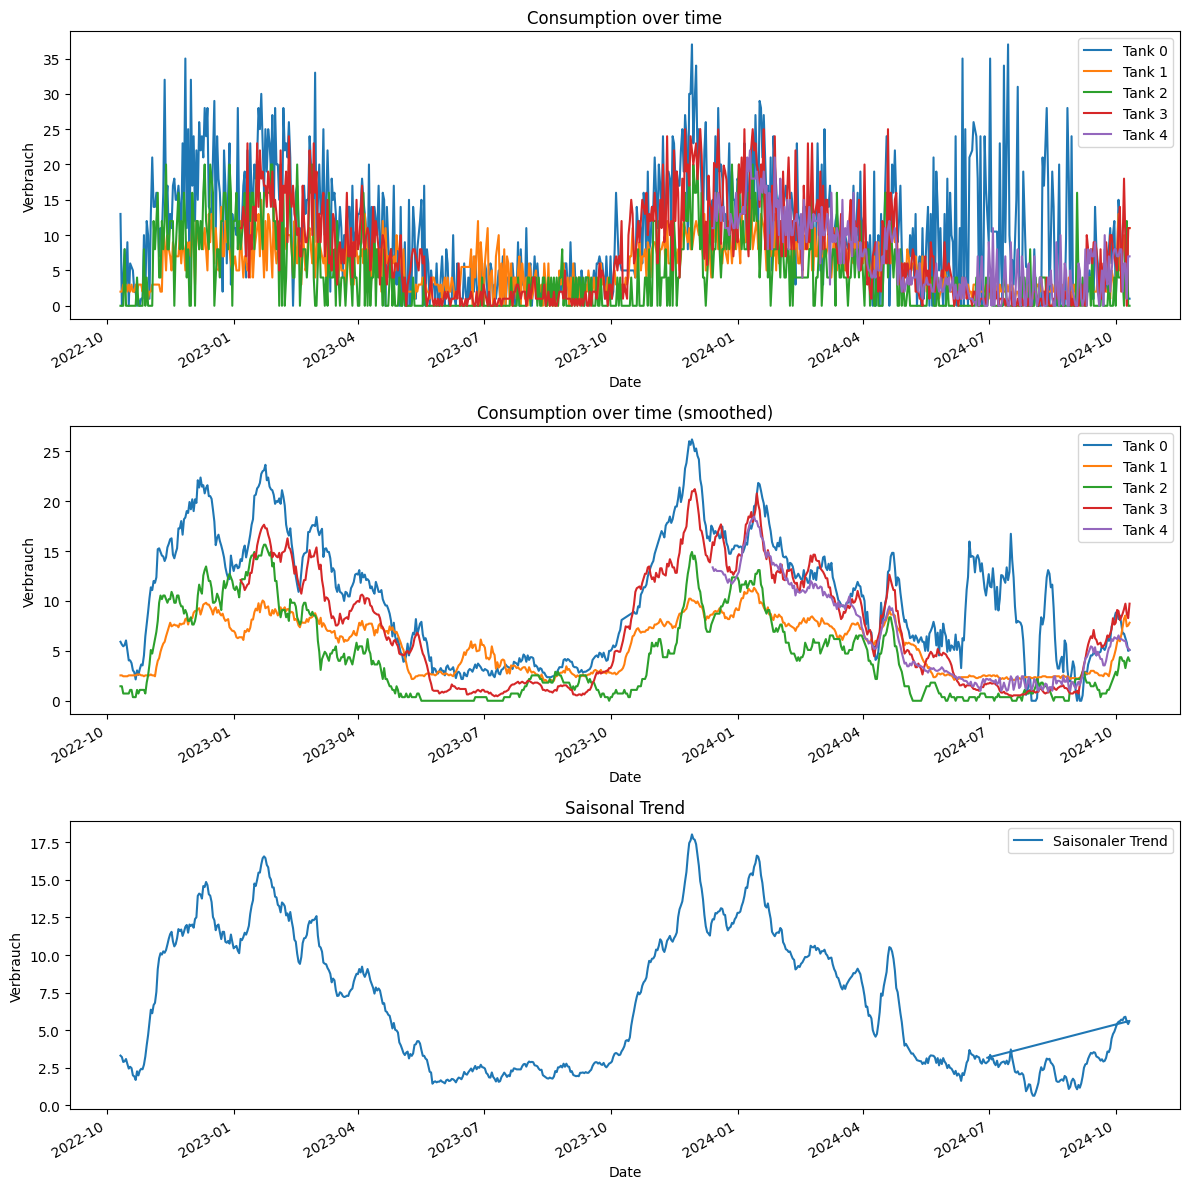

In [9]:
# plot target "Verbrauch" time series based on tank ID
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
for tank_id in df["Tank-ID"].unique():
    df[df["Tank-ID"] == tank_id]["Verbrauch"].plot(ax=axes[0], label=f'Tank {tank_id}')
    df[df["Tank-ID"] == tank_id]["Verbrauch smoothed"].plot(ax=axes[1], label=f'Tank {tank_id}')
df[df["Tank-ID"] == 1]["Saisonaler Trend"].plot(ax=axes[2], label=f'Saisonaler Trend')

axes[0].set_title('Consumption over time')
axes[1].set_title('Consumption over time (smoothed)')
axes[2].set_title('Saisonal Trend')

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Verbrauch')
    ax.legend()

plt.tight_layout()
plt.show()

## Sklearn models

In [10]:
#from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.kernel_ridge import KernelRidge
#from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Train one model per tank id
